In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [27]:
plot_skip = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.alpha'] = 0.6
mpl.rcParams['grid.linestyle'] = '--'

In [15]:
# df = pd.read_pickle("C:/Users/A10739/PycharmProjects/ufos-solution/data61_1_imu_ctrl_speed.pickle")
# df = pd.read_pickle("C:/Users/A10739/PycharmProjects/ufos-solution/data61_2_imu_ctrl_speed.pickle")
# df = pd.read_pickle("C:/Users/A10739/PycharmProjects/ufos-solution/data61_3_imu_ctrl_speed.pickle")
df = pd.read_pickle("/Users/a11910/Documents/42dot/ufos-solution/sensor_axis_alignment/data/processed/data61_1_imu_ctrl_speed.pickle")

In [16]:
df

,t,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,brake,throttle,steering,speed,gear
0,0.01,-0.267555,0.278248,9.802405,0.000000,0.000000,0.000000,100.0,0.0,0.0,0.1,0
1,0.02,-0.267555,0.278248,9.802405,0.000000,0.000000,0.000000,100.0,0.0,0.0,0.1,0
2,0.03,-0.267555,0.278248,9.802405,0.000000,0.000000,0.000000,100.0,0.0,0.0,0.1,0
3,0.04,-0.267555,0.278248,9.802405,0.000000,0.000000,0.000000,100.0,0.0,0.0,0.1,0
4,0.05,-0.267555,0.278248,9.802405,0.000000,0.000000,0.000000,100.0,0.0,0.0,0.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
223517,2235.18,-0.291583,0.215964,9.801656,0.000949,0.001070,0.001989,50.1,18.9,13.9,0.0,4
223518,2235.19,-0.391458,0.218760,9.797514,0.000959,0.000022,0.001039,49.2,18.9,13.9,0.0,4
223519,2235.20,-0.391458,0.218760,9.797514,0.000929,-0.000976,0.001088,49.2,18.9,13.9,0.0,4
223520,2235.21,-0.291583,0.215964,9.801656,-0.000030,-0.000998,0.000049,49.2,18.9,13.9,0.0,4


In [17]:
# 직선 운동 구간 추출

In [18]:
df['gyr_mag'] = np.linalg.norm(df[['gyr_x', 'gyr_y', 'gyr_z']].to_numpy(), axis=1)

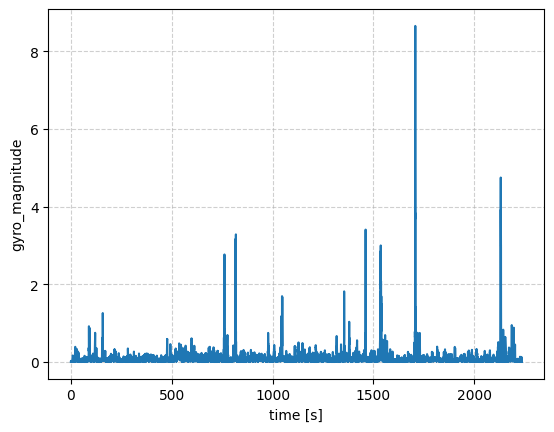

In [28]:
if not plot_skip:
    plt.figure()
    plt.plot(df['t'], df['gyr_mag'])
    plt.xlabel('time [s]')
    plt.ylabel('gyro_magnitude')

In [29]:
std_list = []
for steering_threshold in np.arange(0.1, 20, 0.1):
    std_list.append(df.loc[df.steering.abs() < steering_threshold, 'gyr_mag'].std())

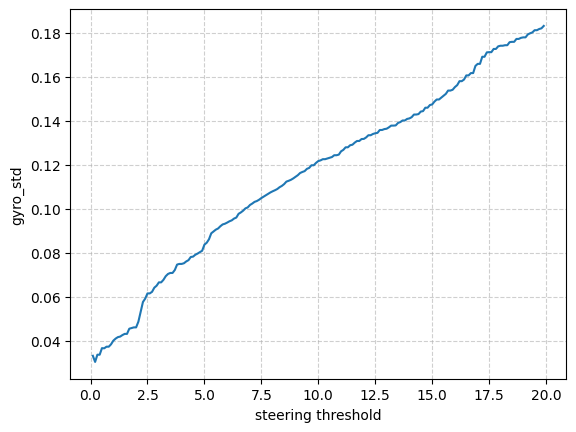

In [31]:
if not plot_skip:
    plt.figure()
    plt.plot(np.arange(0.1, 20, 0.1), std_list)    
    plt.xlabel('steering threshold')
    plt.ylabel('gyro_std')
    plt.show()

조향각의 문턱치에 따른 각속도 벡터 크기의 표준편차를 그래프로 나타내면 위와 같다. 조향각이 커질수록 차량의 회전운동이 커지기 때문에 표준편차도 함께 우상향 하는 형상이 나타난다. 그런데 조향각이 2도 이상인 순간부터 표준편차가 급격히 증가한 것으로 보아, 2도를 기준으로 차량의 회전 운동에 대한 반응성이 크게 달라지는 것으로 볼 수 있다. 

$\therefore$ 직선 주행을 유지하고자 하는 의도로서의 조향각 기준은 2도 이하로 한다.

In [32]:
df['gyr_mag_std'] = df.gyr_mag.rolling(window=100).std()

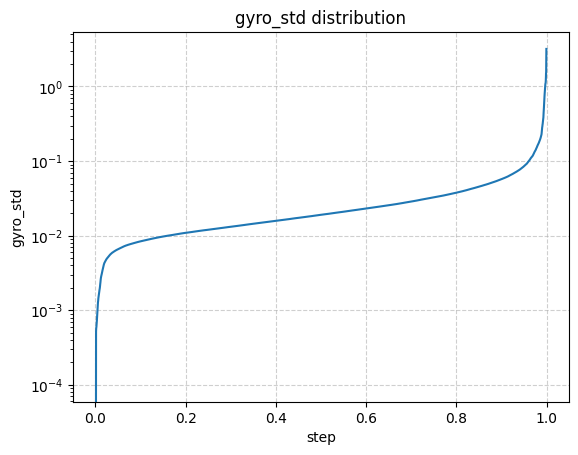

In [33]:
if not plot_skip:
    plt.figure()
    plt.semilogy(np.arange(0, stop=1, step=1/len(df)), df.gyr_mag_std.sort_values().values)
    plt.xlabel('step')
    plt.ylabel('gyro_std')
    plt.title('gyro_std distribution')
    plt.grid(True)
    plt.show()

In [34]:
gyr_mag_std_threshold = df.gyr_mag_std.quantile(0.8)
gyr_mag_std_threshold

0.037697730100436186

1초 간의 각속도 벡터 크기를 계산하고 1초 동안(100샘플)의 표준편차를 계산하였다. 그리고 그것을 크기 순으로 나타내었을 때의 그래프는 위와 같다. 80% 위치에서 표준편차는 0.03770값을 가진다.

In [35]:
twms = 5 * 100 # time window min span. 5 [s] * 100[sample/s]

In [36]:
condition_core = (df['gyr_mag_std'] <= gyr_mag_std_threshold) & (df['steering'] <= 2)
df['gyr_select_flag'] = condition_core.rolling(twms).sum().shift(-twms).rolling(twms).max() == twms

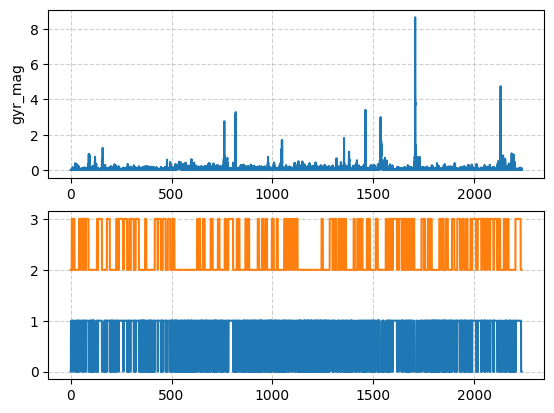

In [37]:
if not plot_skip:
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(df.t, df.gyr_mag)
    plt.ylabel('gyr_mag')
    plt.subplot(2, 1, 2)
    plt.plot(df.t, ((df['gyr_mag_std'] <= gyr_mag_std_threshold) & (df['steering'] <= 2)))
    plt.plot(df.t, df['gyr_select_flag'] + 2)
    plt.show()
    

gyr_select_flag로서 선택된 구간들은 조향각이 작고 각속도의 편차가 크지 않으므로 '직선 운동 구간'을 나타낸다고 볼 수 있다.

In [38]:
# 정지 구간 추출

In [39]:
## 가속도만 활용한 방법

In [40]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as Rot
from copy import deepcopy

In [41]:
norm = np.linalg.norm
det = np.linalg.det
svd = np.linalg.svd

In [42]:
window_size = 2 * 20  # 2s
THRESHOLD_STD = 12/128  # 정지/주행시 진동에 대한 표준편차 차이
threshold_step = 2 * 20  # 얼마나 정지해 있어야 데이터를 사용할 것인가 최초 5s -> 2s

In [43]:
def check_go_stop(x, window_size=window_size, threshold_std=THRESHOLD_STD, threshold_step=threshold_step):
    # stop : 0 / go : 1
    # tic : falling edge (1 -> 0)
    # tac : keep down state (0 -> 0)
    # toc : rising edge (0 -> 1)
    x_std = pd.Series(x).rolling(window=window_size).std()
    x_std[:window_size - 1] = threshold_std
    x_test = (x_std > threshold_std).values

    tic = np.zeros(len(x_test))
    tac = np.ones(len(x_test))
    toc = np.zeros(len(x_test))

    tic[1:] = (x_test[0:-1] == 1) & (x_test[1:] == 0)
    toc[1:] = (x_test[0:-1] == 0) & (x_test[1:] == 1)

    tic_idx = np.where(tic)[0]
    toc_idx = np.where(toc)[0]

    if toc_idx[0] < tic_idx[0]:
        tic_idx = np.hstack((0, tic_idx))

    if toc_idx[-1] < tic_idx[-1]:
        toc_idx = np.hstack((toc_idx, len(x)))

    for i, idx in enumerate(np.array([tic_idx, toc_idx]).T):
        if idx[1] - idx[0] > threshold_step:
            tac[idx[0]:idx[1]] = 0
    tic[1:] = (tac[0:-1] == 1) & (tac[1:] == 0)
    toc[1:] = (tac[0:-1] == 0) & (toc[1:] == 1)
    return tic, tac, toc

In [44]:
def z_align_matrix(a_g):
    a_v = np.array([0, 0, 9.80665])

    u = np.cross(a_g, a_v)

    magnitude = norm(u)
    u = u / magnitude

    cos = np.inner(a_v, a_g) / np.absolute(norm(a_v) * norm(a_g))
    sin = norm(np.cross(a_g, a_v)) / np.absolute(norm(a_v) * norm(a_g))

    L_x = np.array([[0, 0, 0],
                    [0, 0, -1],
                    [0, 1, 0]])
    L_y = np.array(([0, 0, 1],
                    [0, 0, 0],
                    [-1, 0, 0]))
    L_z = np.array(([0, -1, 0],
                    [1, 0, 0],
                    [0, 0, 0]))
    L = [L_x, L_y, L_z]

    I = np.eye(3)

    uL = np.inner(u, L)

    R = I + sin * uL + (1 - cos) * (uL @ uL)

    return R

In [45]:
def xy_align_matrix(covMat):
    U, S, V = np.linalg.svd(covMat)

    U1 = deepcopy(U)
    U2 = deepcopy(U)
    # remove reflection
    if det(U) < 0:
        U1[-1, :] *= -1
        U2[0, :] *= -1

    R1 = np.eye(3)
    R1[0:2, 0:2] = U1
    R2 = np.eye(3)
    R2[0:2, 0:2] = U2

    R1 = Rot.from_matrix(R1)
    R2 = Rot.from_matrix(R2)
    #
    # R1.as_euler('zxy',degrees = True)
    # R2.as_euler('zxy',degrees = True)

    R1 = R1.as_matrix()
    R2 = R2.as_matrix()
    return R1, R2

In [46]:
def remove_flip_state(df):
    def calc_angle_array(df):

        x = df.acc_x.values
        y = df.acc_y.values
        z = df.acc_z.values

        window_size = 200 # 2s
        x_mean = df.acc_x.rolling(window_size).mean().values
        y_mean = df.acc_y.rolling(window_size).mean().values
        z_mean = df.acc_z.rolling(window_size).mean().values

        cos = (x * x_mean + y * y_mean + z * z_mean) / np.sqrt(
            (x ** 2 + y ** 2 + z ** 2) * (x_mean ** 2 + y_mean ** 2 + z_mean ** 2))
        angle = np.arccos(np.clip(cos, -1.0, 1.0))

        return angle

    flip_test = pd.DataFrame()

    flip_test['angle'] = calc_angle_array(df)

    flip_test['angle_flag'] = flip_test.angle.map(lambda x: x > np.pi / 6)
    flip_test['angle_flag_duration'] = flip_test.angle_flag.rolling(25).sum() # 0.25s
    flip_test['angle_flag_duration_flag'] = flip_test.angle_flag_duration.rolling(200).max() # 2s

    cond1 = flip_test.angle_flag_duration_flag.values == 25  # 0.25s
    cond2 = flip_test.angle_flag_duration_flag.shift(1).values != 25  # 0.25s
    flip_test['flip_detection'] = cond1 & cond2

    time_clip = [df.t.values[0]]
    time_clip = time_clip + list(df.t[flip_test.flip_detection == True].values)
    time_clip.append(df.t.values[-1])


    # df_net = df[(time_clip[0] < df.t.values) & (df.t.values < time_clip[1])]
    vector_span_mean = []
    for i in range(1, len(time_clip)):
        temp = df[(df.t.values >= time_clip[i - 1]) & (df.t.values <= time_clip[i])][['t', 'acc_x', 'acc_y', 'acc_z']]
        vector_span_mean.append(np.array([temp.acc_x.mean(), temp.acc_y.mean(), temp.acc_z.mean()]))

    def calc_angle(v1, v2):
        return np.arccos(np.clip(sum(v1 * v2) / np.sqrt(sum(v1 * v1) * sum(v2 * v2)), -1.0, 1.0))

    vector_angle_from_first_time = []
    for i in range(1, len(vector_span_mean)):
        vector_angle_from_first_time.append(calc_angle(vector_span_mean[0], vector_span_mean[i]) * 180 / np.pi)

    selected_span_index = [1]
    for i in range(len(vector_angle_from_first_time)):
        if vector_angle_from_first_time[i] < 10:
            selected_span_index.append(i + 2)
    selected_span_index = np.array(selected_span_index)

    df_set = []
    for i in selected_span_index:
        df_set.append(
            df[(time_clip[i - 1] < df.t.values) & (df.t.values < time_clip[i])])
    df_net = pd.concat(df_set)

    return df_net

In [47]:
df_norm = norm(df[['acc_x', 'acc_y', 'acc_z']].to_numpy(), axis=1)

In [48]:
tic1, tac1, toc1 = check_go_stop(df_norm, window_size=200, threshold_std=12/128, threshold_step=200)

stop_area = tac1 == 0
x_stop = df.acc_x[stop_area]
y_stop = df.acc_y[stop_area]
z_stop = df.acc_z[stop_area]

a_g = np.array([x_stop.mean(), y_stop.mean(), z_stop.mean()])
a_g

array([-0.37560112,  0.38475193,  9.79064631])

In [49]:
# real = np.array([0.03, 0.04, 0.05])
real = np.array([0.12, 0.16, 0.20])
real

array([0.12, 0.16, 0.2 ])

In [50]:
import navpy as nav

In [51]:
R = z_align_matrix(a_g)

z축 정렬 이후 xy축 정렬을 어떻게 하는지에 따라 방법이 나뉜다.
1. Covariance Matrix의 Eigen Vector를 이용하여 구하는 방법
    1. 전체 가속도를 이용하는 방법
    2. 자이로와 조향각을 기준으로 선택된 가속도를 이용하는 방법
1. 전진 가속 시의 가속도 벡터의 평균을 전진방향으로 구하는 방법
    1. 1-2의 기준으로 선택된 가속도 중 크기가 큰 것만 선택하여 평균
    2. 엑셀과 브레이크 패달 입력 활용

A & B
A의 방법대로 1차로 정렬한 다음 B의 방법을 활용


## xy축 정렬 / Cov. Mat. / 전체 가속도를 이용

In [52]:
# xy-alignment
P = df[['acc_x', 'acc_y', 'acc_z']].to_numpy().T
P_rot = R @ P

In [53]:
np.cov(P_rot[0:2, :])

array([[22.29899683, -1.12335734],
       [-1.12335734, 11.76846356]])

In [54]:
R1, R2 = xy_align_matrix(np.cov(P_rot[0:2, :]))
R_fin = R1 @ R

In [55]:
# rotation matrix를 구했으면 이걸 각도로 변환시키고, 실제 값이랑 비교해보자.
res1 = np.array(nav.dcm2angle(R_fin)) + [-np.pi, 0, 0] #*360/np.pi #
res1

array([-0.10436044,  0.04222314,  0.03504214])

In [56]:
err1 = (res1 - real)#*360/np.pi
err1

array([-0.22436044, -0.11777686, -0.16495786])

## xy축 정렬 / Cov. Mat. / 자이로와 조향각을 기준으로 선택된 가속도를 이용

In [57]:
# xy-alignment
P = df.loc[df.gyr_select_flag, ['acc_x', 'acc_y', 'acc_z']].to_numpy().T
P_rot = R @ P

In [58]:
np.cov(P_rot[0:2, :])

array([[ 2.00576824, -0.01027801],
       [-0.01027801,  1.08385924]])

In [59]:
R1, R2 = xy_align_matrix(np.cov(P_rot[0:2, :]))
R_fin = R1 @ R

In [60]:
res2 = np.array(nav.dcm2angle(R_fin)) + [-np.pi, 0, 0] #*360/np.pi #
res2

array([-0.01039389,  0.03875023,  0.0388483 ])

In [61]:
err2 = (res2 - real)#*360/np.pi
err2

array([-0.13039389, -0.12124977, -0.1611517 ])

## xy축 정렬 / Acc. Avg. / 자이로와 조향각을 기준으로 선택된 가속도 중 크기가 큰 것을 선별하여 이용

x, y축 정렬 전에 가속도 값이 어떻게 분포되어 있는지 확인한다.

In [131]:
test = df.loc[df.gyr_select_flag, ['acc_x', 'acc_y', 'acc_z']].to_numpy().T
test2 = R_fin @ test
# R_fin

In [140]:
df_test = pd.DataFrame()
df_test['acc_x'] = test2[0, :]
df_test['acc_y'] = test2[1, :]
df_test['a_xy'] = norm(df_test, axis=1)
df_test

,acc_x,acc_y,a_xy
0,-0.036557,-0.144114,0.148678
1,-0.036557,-0.144114,0.148678
2,-0.036557,-0.144114,0.148678
3,-0.036557,-0.144114,0.148678
4,-0.036557,-0.144114,0.148678
...,...,...,...
88847,3.008320,-4.737218,5.611704
88848,3.150945,-4.734343,5.687043
88849,3.222798,-4.803612,5.784558
88850,3.416169,-5.023160,6.074730


[Text(0.5, 1.0, 'before')]

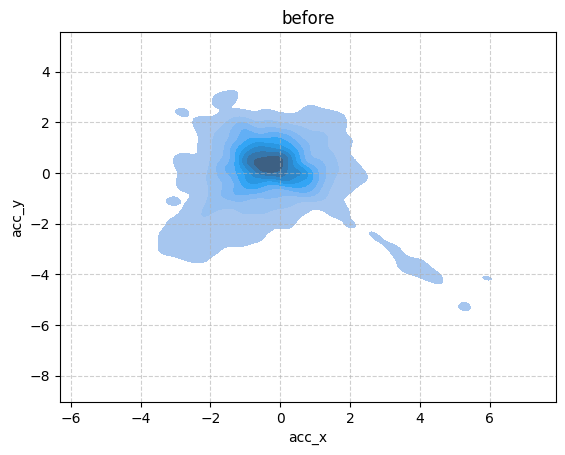

In [145]:
sns.kdeplot(data = df_test[['acc_x','acc_y']], x='acc_x', y='acc_y', fill=True).set(title='before')

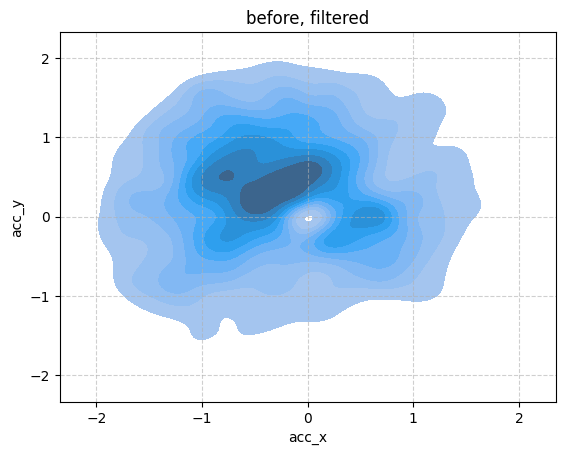

In [147]:
if not plot_skip:
    sns.kdeplot(data = df_test.loc[(df_test.a_xy >= 0.25) & (df_xy.a_xy <= 2), ['acc_x', 'acc_y']],
                x='acc_x', y='acc_y', fill=True
    ).set(title='before, filtered')

- 축 정렬 이후 분포가 어떻게 바뀌는지 확인한다.
- 이때, 직선 구간으로 뽑은 가속도 값들 중에서도 극단에 있는 애들을 제외해야 오차가 준다.
- 따라서 percentile로 경계값들을 계산하고, 그 값들을 기준으로 축정렬한다.

In [62]:
P = df.loc[df.gyr_select_flag, ['acc_x', 'acc_y', 'acc_z']].to_numpy().T
P_rot = R @ P

In [63]:
a_xy = norm(P_rot[0:2, :], axis=0)

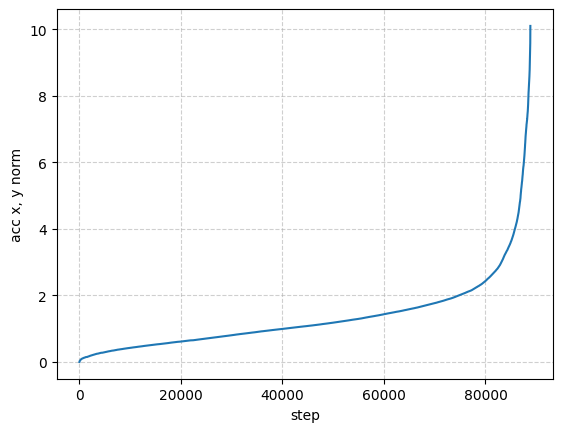

In [66]:
if not plot_skip:
    plt.figure()
    plt.plot(np.sort(a_xy))
    plt.xlabel('step')
    plt.ylabel('acc x, y norm')
    plt.show()

In [67]:
a_xy_qs = np.quantile(a_xy, [0.25, 0.75, 0.85])
a_xy_qs

array([0.65081325, 1.63970149, 2.04500138])

In [78]:
df_xy = pd.DataFrame({'a_x': P_rot[0,:], 'a_y': P_rot[1,:], 'a_xy': a_xy})

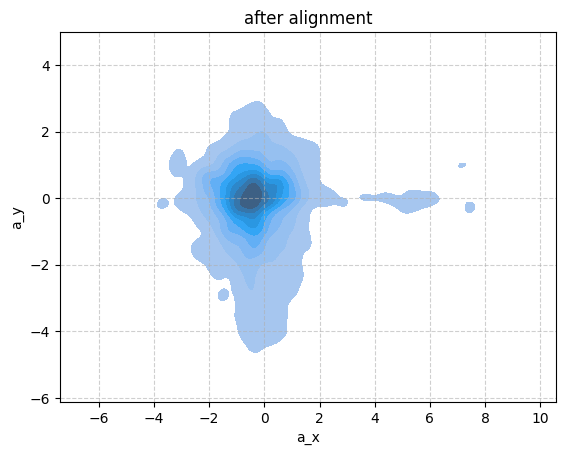

In [158]:
if not plot_skip:
    sns.kdeplot(data = df_xy[['a_x', 'a_y']], x='a_x', y='a_y', fill=True).set(title='after alignment')

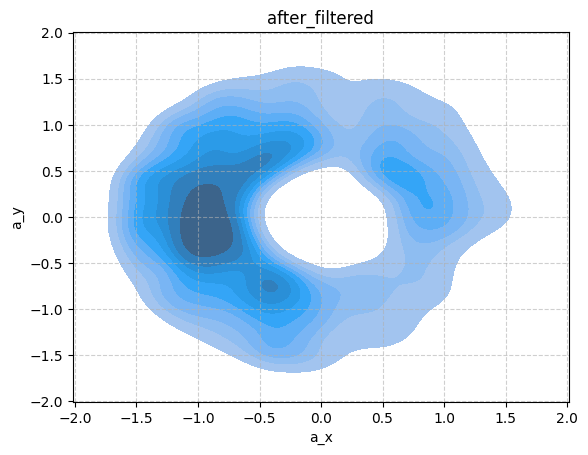

In [150]:
# 25%, 75% 기준
if not plot_skip:
    sns.kdeplot(data = df_xy.loc[(df_xy.a_xy >= a_xy_qs[0]) & (df_xy.a_xy <= a_xy_qs[1]), ['a_x', 'a_y']],
                x='a_x', y='a_y', fill=True
    ).set_title('after_filtered')


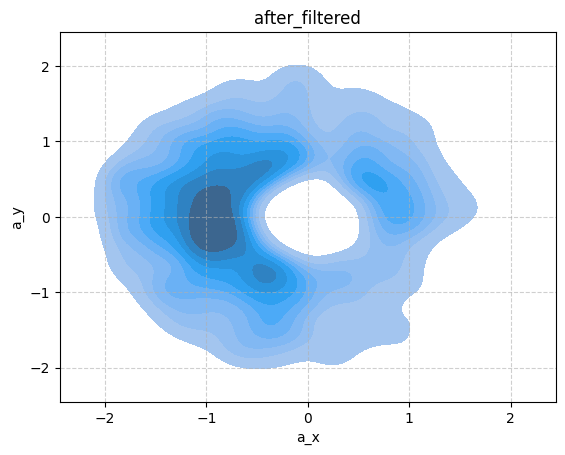

In [151]:
# 25%, 85% 기준
if not plot_skip:
    sns.kdeplot(data = df_xy.loc[(df_xy.a_xy >= a_xy_qs[0]) & (df_xy.a_xy <= a_xy_qs[2]), ['a_x', 'a_y']],
                x='a_x', y='a_y', fill=True
    ).set_title('after_filtered')


In [81]:
P_rot_select = df_xy.loc[(df_xy.a_xy >= a_xy_qs[0]) & (df_xy.a_xy <= a_xy_qs[2]), ['a_x', 'a_y']].to_numpy().T

In [85]:
R1, R2 = xy_align_matrix(np.cov(P_rot_select))
R_fin = R2 @ R

In [86]:
res3 = [x - np.sign(x) * np.pi if np.abs(x) > np.pi/2 else x for x in np.abs(np.array(nav.dcm2angle(R_fin)))]
res3

[-1.110880913448491, 0.018184071359311545, 0.051765336049916136]

In [87]:
err3 = np.array(res3) - np.array([0.12, 0.16, 0.20])
err3

array([-1.23088091, -0.14181593, -0.14823466])

In [88]:
# x, y 축을 align 할 때 사용할 가속도 벡터 크기의 절대 값을 0.25, 2 로 고정하고 테스트해본다.

P_rot_select = df_xy.loc[(df_xy.a_xy >= 0.25) & (df_xy.a_xy <= 2), ['a_x', 'a_y']].to_numpy().T
R1, R2 = xy_align_matrix(np.cov(P_rot_select))
R_fin = R2 @ R

In [89]:
res3 = [x - np.sign(x) * np.pi if np.abs(x) > np.pi/2 else x for x in np.abs(np.array(nav.dcm2angle(R_fin)))]
res3

[0.7489823574139868, 0.0013388640642218448, 0.05484728158896574]

In [90]:
err3 = np.array(res3) - np.array([0.12, 0.16, 0.20])
err3

array([ 0.62898236, -0.15866114, -0.14515272])

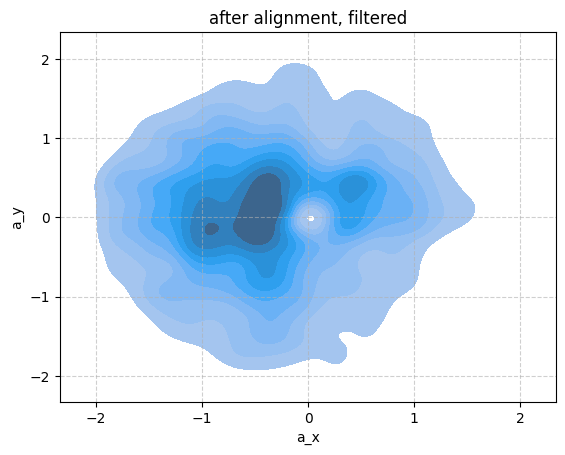

In [160]:
if not plot_skip:
    sns.kdeplot(data = df_xy.loc[(df_xy.a_xy >= 0.25) & (df_xy.a_xy <= 2), ['a_x', 'a_y']],
                x='a_x', y='a_y', fill=True
    ).set_title('after alignment, filtered')


xy정렬을 마무리 하기 위해서는 앞뒤 구분을 할 수 있어야한다. (R1과 R2 중에 어떤 것을 고를지 선택)

1. 가속도만 활용하는 방법 : 정지상태에서 출발할 때가 전진방향
    - 취약점
        - 데이터가 짧고 주차장에서 후진을 많이 반복한 경우를 예외처리 필요
        - 정지 -> 출발 횟수가 많지 않은 단순한 경로인 경우 참고 데이터가 적어서 부정확해짐
2. 가속도 + 속도 : 속도가 증가할 때 가속 방향이 전진방향.
    - 취약점 : 데이터가 짧고 후진 가속하는 특이한 경우에는 예외처리 필요.
    - 취약점 개선 방안
        - 후진 가능성이 높은 주차장 구역 패턴 제외 :
            - 전진&후진 반복되는 구간 제외하고 전진 패턴 분석
            - 후진으로는 도달하기 힘든 속도가 일정 시간 유지되는 구간의 패턴 분석
3. 가속도 + 속도 + 기어상태 : 2에서 기어 상태를 활용하여 전진/후진 구분하고 패턴 분석

In [55]:
# 방법 1
# test = R1 @ P_rot
#
# x = pd.Series(test[0, :])
#
# tic2, tac2, toc2 = check_go_stop(x, window_size=200, threshold_std=THRESHOLD_STD/128, threshold_step=200)
#
# toc_idx = np.where(toc2)
# if len(toc_idx[0]) == 0:
#     toc_idx = np.where(toc1)[0]
#
# tic_idx = np.where(tic2)
# if len(tic_idx[0]) == 0:
#     tic_idx = np.where(tic1)[0]
#
# forward = np.mean(x.values[np.hstack((toc_idx[0], toc_idx[0] - 1, toc_idx[0] - 2))])
# backward = np.mean(x.values[np.hstack((tic_idx[0], tic_idx[0] - 1, tic_idx[0] - 2))])
#
# if forward > backward:
#     R_fin = R1 @ R
# else:
#     R_fin = R2 @ R

In [161]:
# 방법 3
df['speed_mean'] = df.speed.rolling(window=100).mean().shift(-50)
df['dv'] = df.speed_mean - df.speed_mean.shift(1)

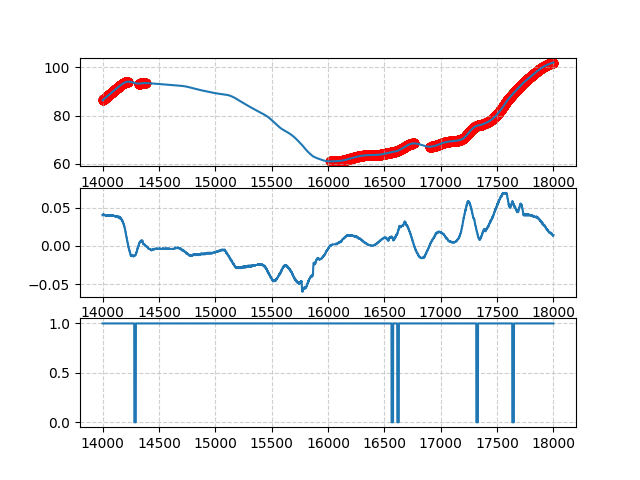

In [163]:
%matplotlib widget

if not plot_skip:
    i_from = 14000
    i_to = 18000
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(df.loc[i_from:i_to, 'speed_mean'])
    test = df[i_from:i_to].loc[df[i_from:i_to].dv > 0, 'speed_mean']
    plt.scatter(test.index, test.values, color = 'g')

    test2 = df[i_from:i_to].loc[(df[i_from:i_to].dv > 0) & (df[i_from:i_to].gear > 0), 'speed_mean']
    plt.scatter(test2.index, test2.values, color = 'r')

    plt.subplot(3,1,2)
    plt.plot(df.loc[i_from:i_to, 'dv'])

    plt.subplot(3,1,3)
    plt.plot(df.loc[i_from:i_to, 'gear'] > 0)
    plt.show()

In [164]:
df['accel_span_flag'] = (df.dv > 0) & (df.gear > 0)

In [165]:
P_dir_test = df.loc[df.gyr_select_flag & df['accel_span_flag'], ['acc_x', 'acc_y', 'acc_z']].to_numpy().T
P_dir_test_rot = (R1 @ R) @ P_dir_test

In [166]:
test_index = P_dir_test_rot[0,:].mean()
test_index

0.6797195222990534

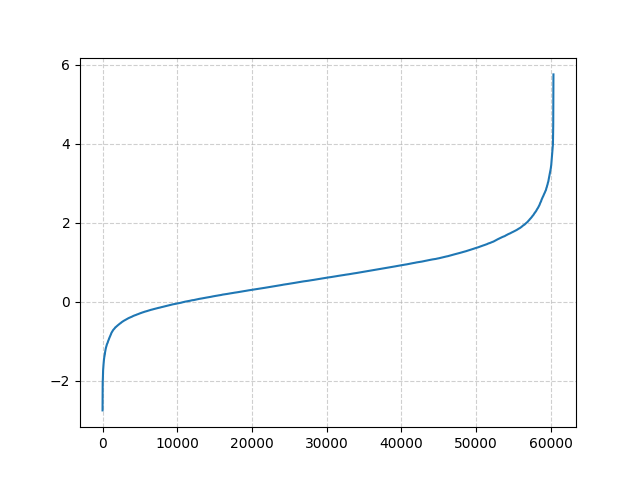

In [167]:
if not plot_skip:
    plt.figure()
    plt.plot(np.sort(P_dir_test_rot[0,:]))
    plt.show()

In [168]:
P_dir_test2 = df.loc[~(df.gyr_select_flag & df['accel_span_flag']), ['acc_x', 'acc_y', 'acc_z']].to_numpy().T
P_dir_test_rot2 = (R1 @ R) @ P_dir_test2

In [169]:
test_index2 = P_dir_test_rot2[0,:].mean()
test_index2

-0.3380436247123366

In [170]:
if test_index > 0:
    R_fin = R1 @ R
else:
    R_fin = R2 @ R

In [171]:
R_fin

array([[-0.7323815 , -0.6808932 , -0.00133886],
       [ 0.67981617, -0.73133082,  0.05481974],
       [-0.03830554,  0.03923878,  0.99849537]])

# 레버암 추정

In [172]:
acc = R_fin @ df[['acc_x', 'acc_y', 'acc_z']].to_numpy().T
acc.shape

(3, 223522)

In [173]:
gyr = R_fin @ df[['gyr_x', 'gyr_y', 'gyr_z']].to_numpy().T

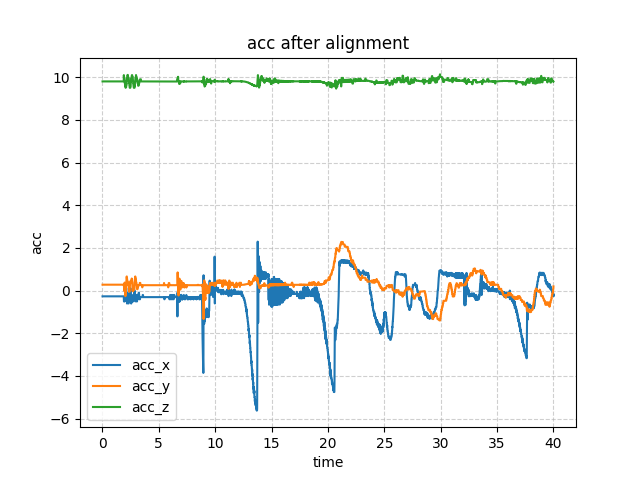

In [180]:
figure_df = df[0:4000]
plt.figure()
plt.plot(figure_df.t, figure_df.acc_x, label='acc_x')
plt.plot(figure_df.t, figure_df.acc_y, label='acc_y')
plt.plot(figure_df.t, figure_df.acc_z, label='acc_z')
plt.title('acc after alignment')
plt.xlabel('time')
plt.ylabel('acc')
plt.legend()

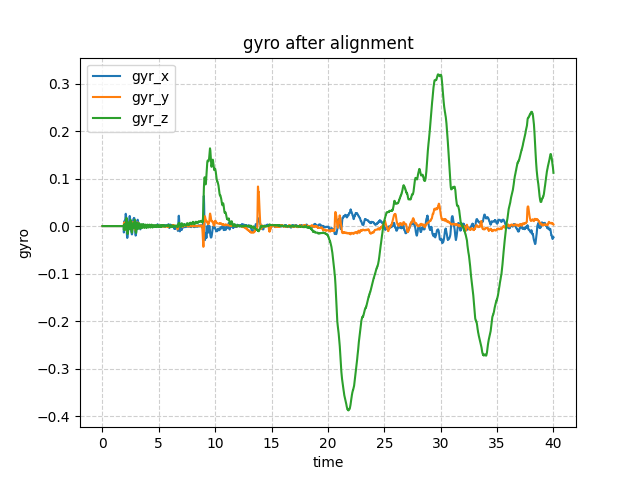

In [182]:
figure_df = df[0:4000]
plt.figure()
plt.plot(figure_df.t, figure_df.gyr_x, label='gyr_x')
plt.plot(figure_df.t, figure_df.gyr_y, label='gyr_y')
plt.plot(figure_df.t, figure_df.gyr_z, label='gyr_z')
plt.title('gyro after alignment')
plt.xlabel('time')
plt.ylabel('gyro')
plt.legend()

In [70]:
len(df), df['gyr_select_flag'].sum()

(223522, 88852)

In [71]:
df_aligned = pd.DataFrame({
    'acc_x': acc[0,:],
    'acc_y': acc[1,:],
    'acc_z': acc[2,:],
    'gyr_x': gyr[0,:],
    'gyr_y': gyr[1,:],
    'gyr_z': gyr[2,:],
    'steering': df.steering
})

In [72]:
df_aligned

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,steering
0,0.017554,0.164901,9.828853,0.000000,0.000000,0.000000,0.0
1,0.008292,0.164030,9.798629,0.000000,0.000000,0.000000,0.0
2,0.008292,0.164030,9.798629,0.000000,0.000000,0.000000,0.0
3,0.008292,0.164030,9.798629,0.000000,0.000000,0.000000,0.0
4,0.008292,0.164030,9.798629,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...
223517,0.223502,0.144601,9.821273,-0.000862,0.000640,0.002202,13.9
223518,0.343136,0.149447,9.834099,-0.000871,-0.000233,0.001089,13.9
223519,0.353126,0.149837,9.834334,-0.000765,-0.001219,0.000964,13.9
223520,0.262976,0.146487,9.842207,0.000107,-0.000986,-0.000126,13.9


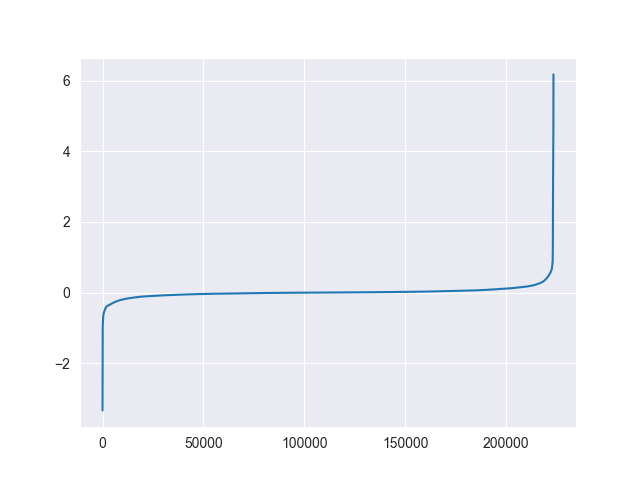

In [73]:
if not plot_skip:
    plt.figure()
    plt.plot(np.sort(df_aligned.gyr_z))
    plt.show()

In [74]:
gyr_z_qs = df_aligned.gyr_z.quantile([0.2,0.8])
gyr_z_qs

0.2   -0.048518
0.8    0.049608
Name: gyr_z, dtype: float64

In [75]:
test = df_aligned[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].to_numpy().T

In [98]:
np.corrcoef(test)

array([[ 1.00000000e+00,  1.17064472e-01,  6.72969000e-03,
         4.79522576e-02,  5.44482404e-03, -7.88272093e-04],
       [ 1.17064472e-01,  1.00000000e+00, -1.06452134e-01,
        -3.41286461e-02,  5.66348130e-02, -5.73106861e-01],
       [ 6.72969000e-03, -1.06452134e-01,  1.00000000e+00,
        -1.36765030e-01,  3.46691465e-01,  1.18727313e-01],
       [ 4.79522576e-02, -3.41286461e-02, -1.36765030e-01,
         1.00000000e+00, -4.63570280e-02,  5.63892777e-02],
       [ 5.44482404e-03,  5.66348130e-02,  3.46691465e-01,
        -4.63570280e-02,  1.00000000e+00,  1.31189647e-01],
       [-7.88272093e-04, -5.73106861e-01,  1.18727313e-01,
         5.63892777e-02,  1.31189647e-01,  1.00000000e+00]])